# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [1]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.microscopy.ome as ome

In [27]:
fiducial_dir = Path(r'F:\Research\LINK\System calibration\2019-10-04 - 4x and 20x Fiducial')

fourx_settings_path = Path(fiducial_dir, r'4x settings.ome.tif')
fourx_path = Path(fiducial_dir, r'4x fiducial stitched.tif')

twentyx_settings_path = Path(fiducial_dir, r'20x settings.ome.tif')
twentyx_path = Path(fiducial_dir, r'20x fiducial _256 res _ stitched.tif')

Open the images

In [28]:
fourx_image = coord.open_microscopy(fourx_path, fourx_settings_path, downsample_factor=1)

In [29]:
twentyx_image = coord.open_microscopy(twentyx_path, twentyx_settings_path, downsample_factor=1)

Acquire similar points between images

<IPython.core.display.Javascript object>


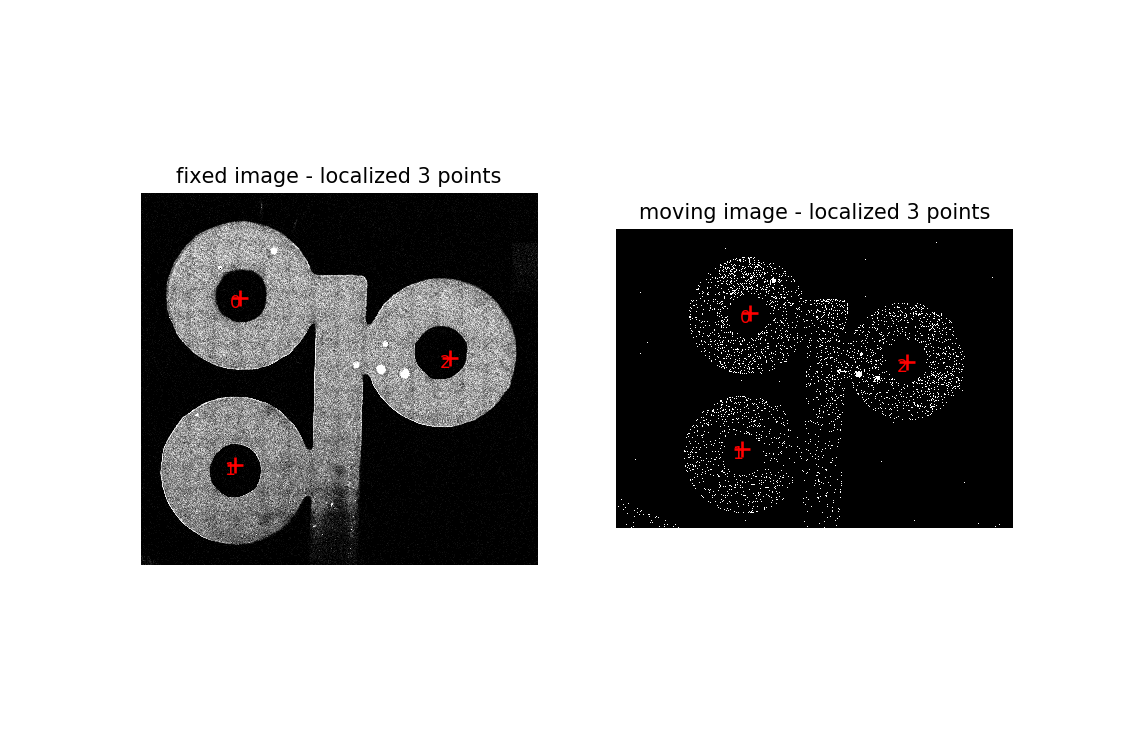

In [32]:
points = iplt.RegistrationPointDataAcquisition(twentyx_image, fourx_image)

In [41]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [42]:
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)

In [43]:
final_transform, metric, stop = reg.register(twentyx_image, fourx_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [44]:
coordinate_transform = np.array(final_params)

In [45]:
registered_fourx = tran.apply_transform_params(twentyx_image, fourx_image, 
                                     coordinate_transform,
                                     sitk.VersorRigid3DTransform())

Box(children=(IntSlider(value=2, description='image slice:', max=4),))

<IPython.core.display.Javascript object>


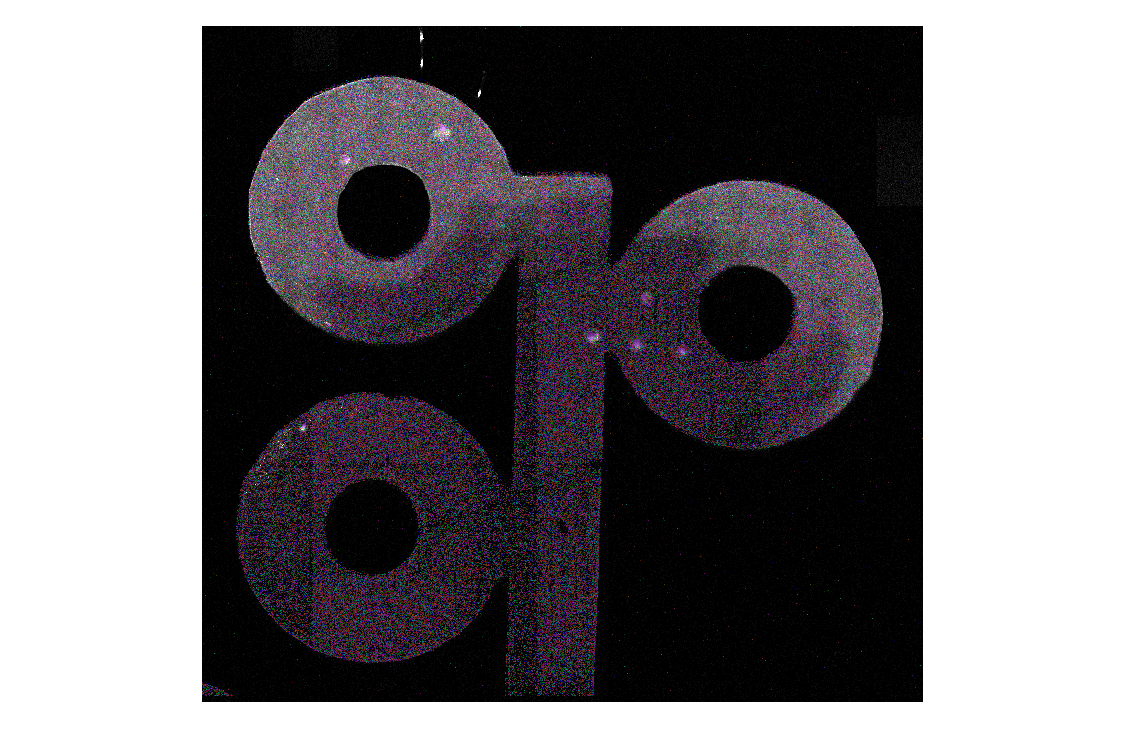

In [46]:
iplt.MultiImageDisplay([sitk.LabelOverlay(twentyx_image, registered_fourx)])

In [47]:
# Save the results
coordinate_path = Path(fiducial_dir, 'OCT to SHG.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)

In [48]:
reg_path = Path(fiducial_dir, 'Fourx registered to twentyx.tif')
sitk.WriteImage(registered_fourx, str(reg_path))